In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


from pyipn import copy_template, Universe

<IPython.core.display.Javascript object>


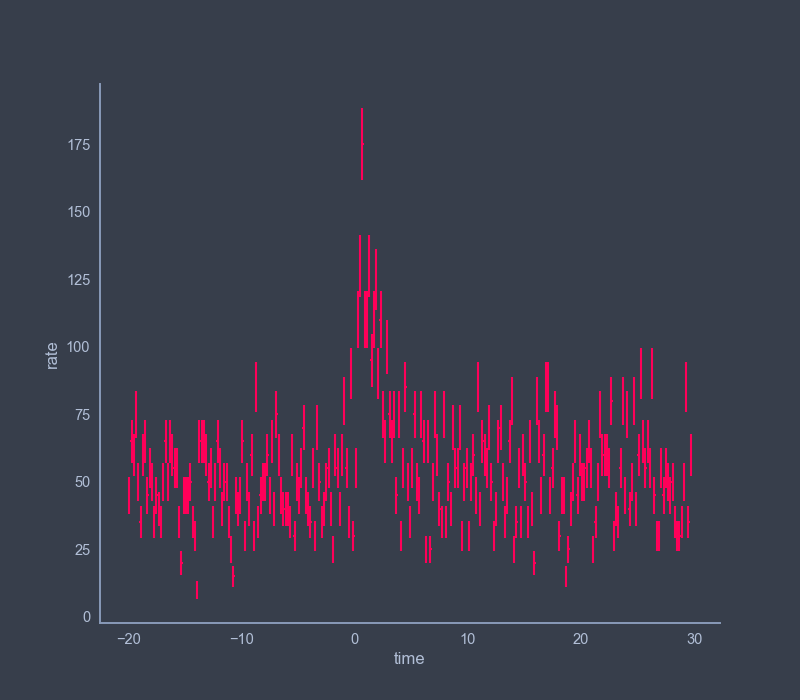

<IPython.core.display.Javascript object>


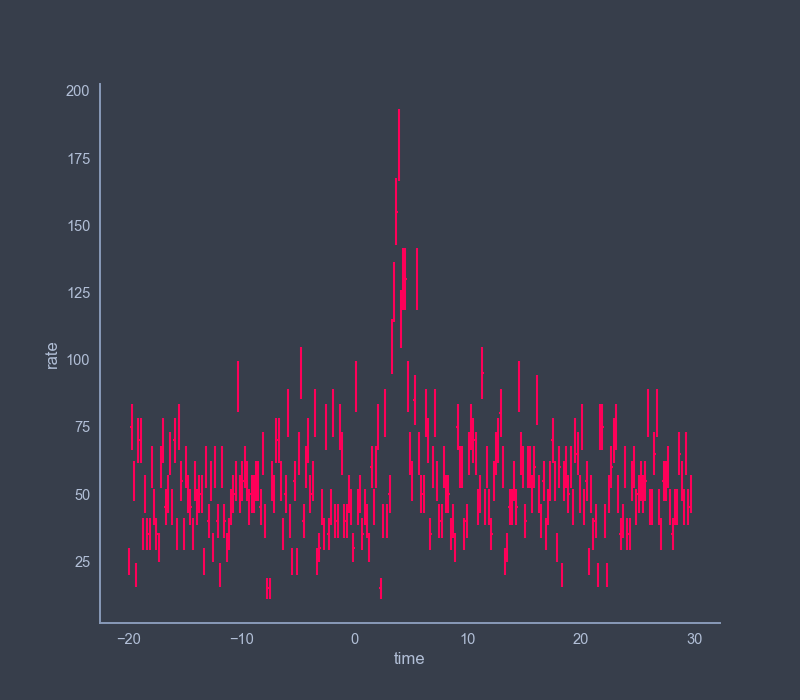

In [54]:

uni = Universe.from_yaml('template_config.yaml')
uni.explode_grb(tstart=-50,tstop=100)
for det, lc in uni.light_curves.items():

    lc.display(-20,30,.2,color=red)



In [3]:
uni._time_differences

array([0.        , 2.96784228])

In [55]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-20.4,31.4,.25)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-20,30,.2)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]
k=50

N_model = 200

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            bw=.7b,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time
           
           
           
           )

In [56]:
model = stan_utility.compile_model('rff.stan', model_name='rff')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff_f9cdf712d06fc13dd2a990979976b4df NOW.


In [57]:
fit = model.sampling(warmup=1500,iter=2000,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=15, adapt_delta=.9)
                    

                    )

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<IPython.core.display.Javascript object>


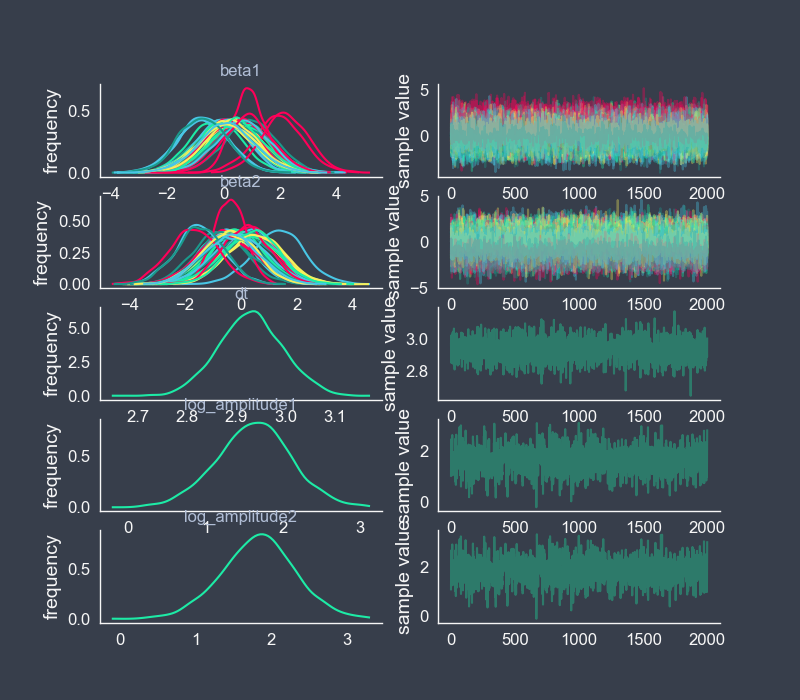

In [59]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt',
              'log_amplitude1',
               'log_amplitude2',
 #             'tstart',
         #     'tstop'
             
             ]);

<IPython.core.display.Javascript object>


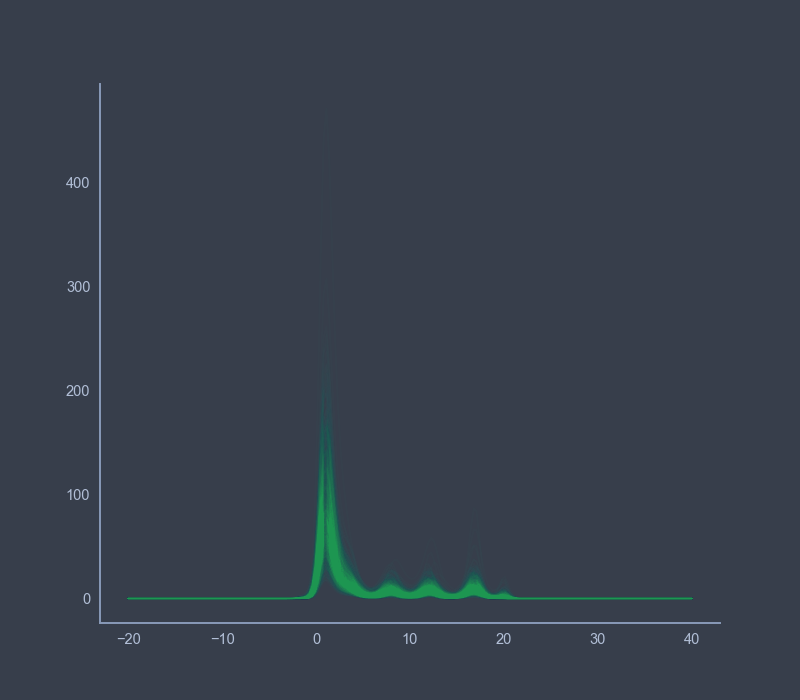

In [60]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::2]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


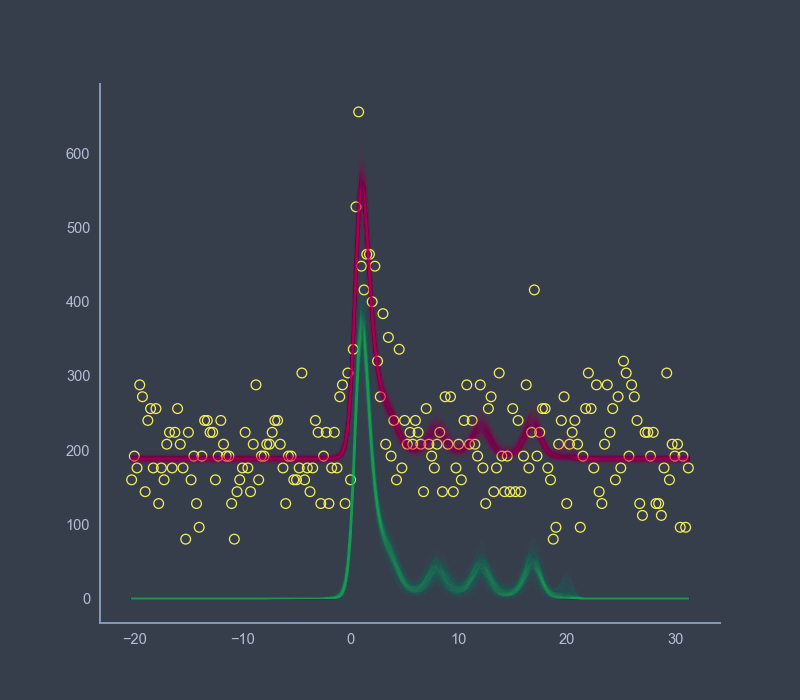

In [61]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts/width, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


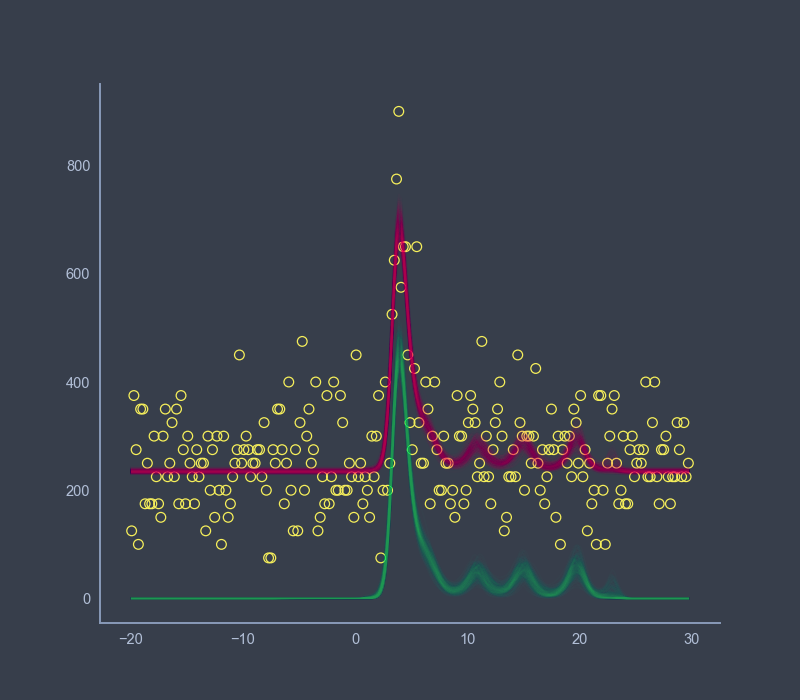

In [62]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2/width2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


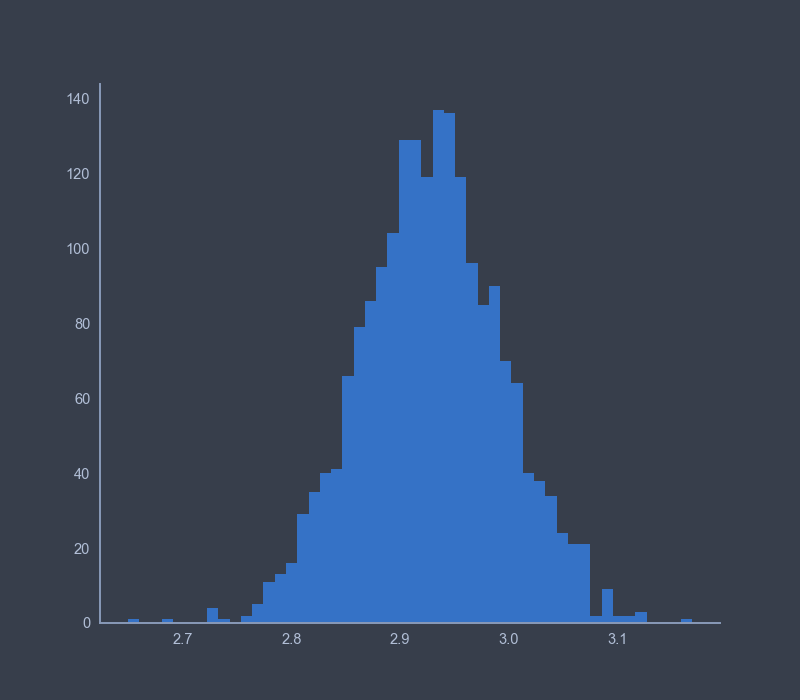

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   4.,   1.,   0.,   2.,
          5.,  11.,  13.,  16.,  29.,  35.,  40.,  41.,  66.,  79.,  86.,
         95., 104., 129., 129., 119., 137., 136., 119.,  96.,  85.,  90.,
         70.,  64.,  40.,  38.,  34.,  24.,  21.,  21.,   2.,   9.,   2.,
          2.,   3.,   0.,   0.,   0.,   1.]),
 array([2.64938614, 2.6597706 , 2.67015506, 2.68053952, 2.69092398,
        2.70130844, 2.7116929 , 2.72207736, 2.73246183, 2.74284629,
        2.75323075, 2.76361521, 2.77399967, 2.78438413, 2.79476859,
        2.80515305, 2.81553751, 2.82592197, 2.83630643, 2.8466909 ,
        2.85707536, 2.86745982, 2.87784428, 2.88822874, 2.8986132 ,
        2.90899766, 2.91938212, 2.92976658, 2.94015104, 2.9505355 ,
        2.96091997, 2.97130443, 2.98168889, 2.99207335, 3.00245781,
        3.01284227, 3.02322673, 3.03361119, 3.04399565, 3.05438011,
        3.06476458, 3.07514904, 3.0855335 , 3.09591796, 3.10630242,
        3.11668688, 3.12707134, 3.1374558 , 3.

In [63]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

<IPython.core.display.Javascript object>


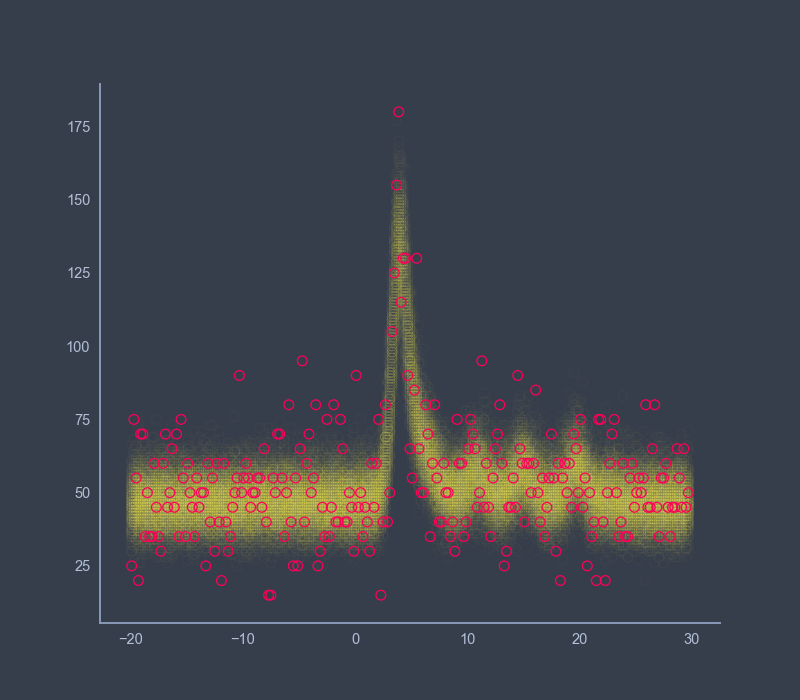

In [65]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


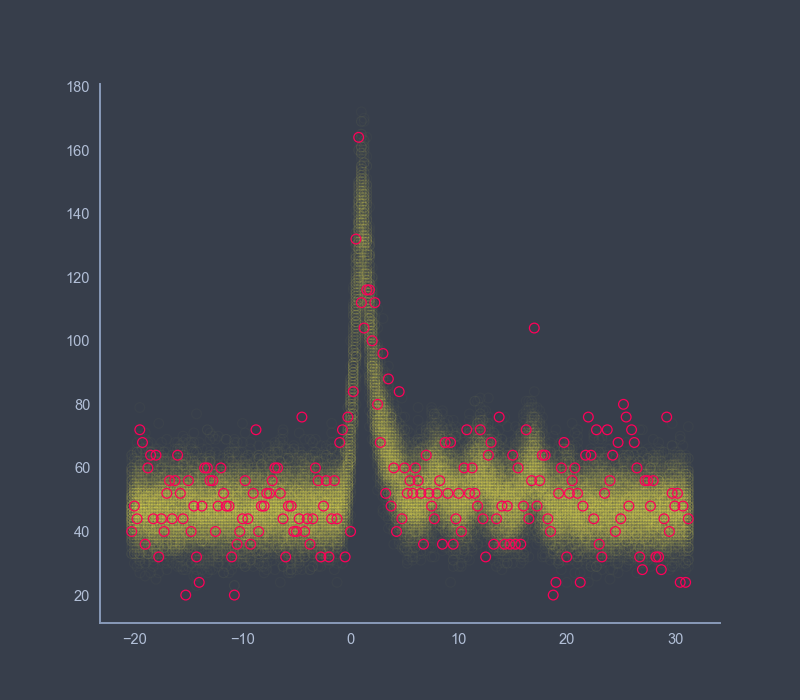

In [66]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)